# Analyze Box Office Data with Seaborn and Python

In [85]:
import pandas as pd
pd.set_option('max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk

In [1]:
# !pip install wordcloud
#from wordcloud import WordCloud

# Data Loading and Exploration

In [16]:
train = pd.read_csv('https://raw.githubusercontent.com/jjone36/tmdb/master/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/jjone36/tmdb/master/data/test.csv')

In [19]:
train.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


# Visualizing the Target Distribution

In [21]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

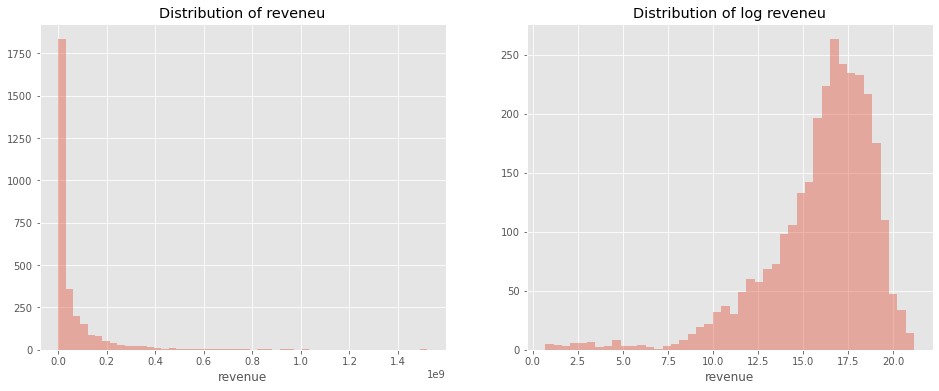

In [32]:
#train.revenue.hist()
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(train['revenue'],kde=False);
plt.title('Distribution of reveneu');
plt.subplot(1,2,2)
sns.distplot(np.log1p(train['revenue']),kde=False);
plt.title('Distribution of log reveneu');

In [34]:
train['log_revenu']=np.log1p(train['revenue'])

# Relationship between Film Revenue and Budget

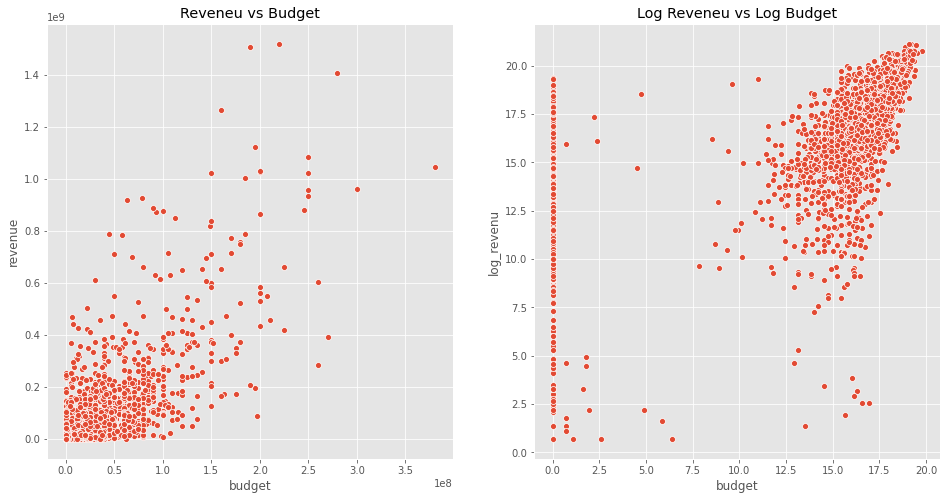

In [48]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(train['budget'],train['revenue'])
plt.title('Reveneu vs Budget');
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train['budget']),train['log_revenu'])
plt.title('Log Reveneu vs Log Budget');

In [50]:
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])

# Does having an Official Homepage Affect Revenue?

In [54]:
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                           4
http://www.thehobbit.com/                                   2
http://www.lordoftherings.net/                              2
http://www.aiweiweifilm.org/                                1
http://www.foxsearchlight.com/snowflowerandthesecretfan/    1
http://www.thegodfather.com/                                1
http://www.thismeanswarmovie.com/                           1
http://www.picturememovie.com/                              1
http://movies.uip.de/aboutaboy/                             1
http://www.labelleetlabete-lefilm.com/                      1
Name: homepage, dtype: int64

In [56]:
train['has_home_page']=0
train.loc[train['homepage'].isnull()==False,'has_home_page']=1
test['has_home_page']=0
test.loc[test['homepage'].isnull()==False,'has_home_page']=1

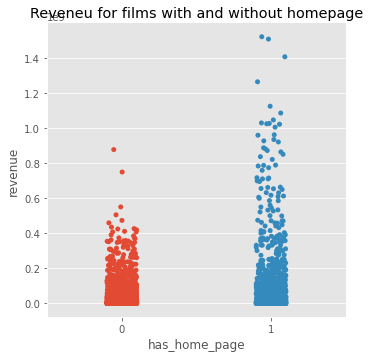

In [58]:
sns.catplot(x='has_home_page',y='revenue',data=train);
plt.title('Reveneu for films with and without homepage');

# Distribution of Languages in Film

In [73]:
train.loc[train['original_language'].isin(train['original_language'])]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,log_revenu,log_budget,has_home_page
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,16.326300,16.454568,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,18.370959,17.504390,0
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,16.387512,15.009433,1
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,16.588099,13.997833,1
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,15.182615,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,/j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",1596687,14.283442,0.000000,0
2996,2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id'

In [80]:
train['original_language'].isin(train['original_language'])#.value_counts())

0       True
1       True
2       True
3       True
4       True
        ... 
2995    True
2996    True
2997    True
2998    True
2999    True
Name: original_language, Length: 3000, dtype: bool

# Frequent Words in Film Titles and Descriptions

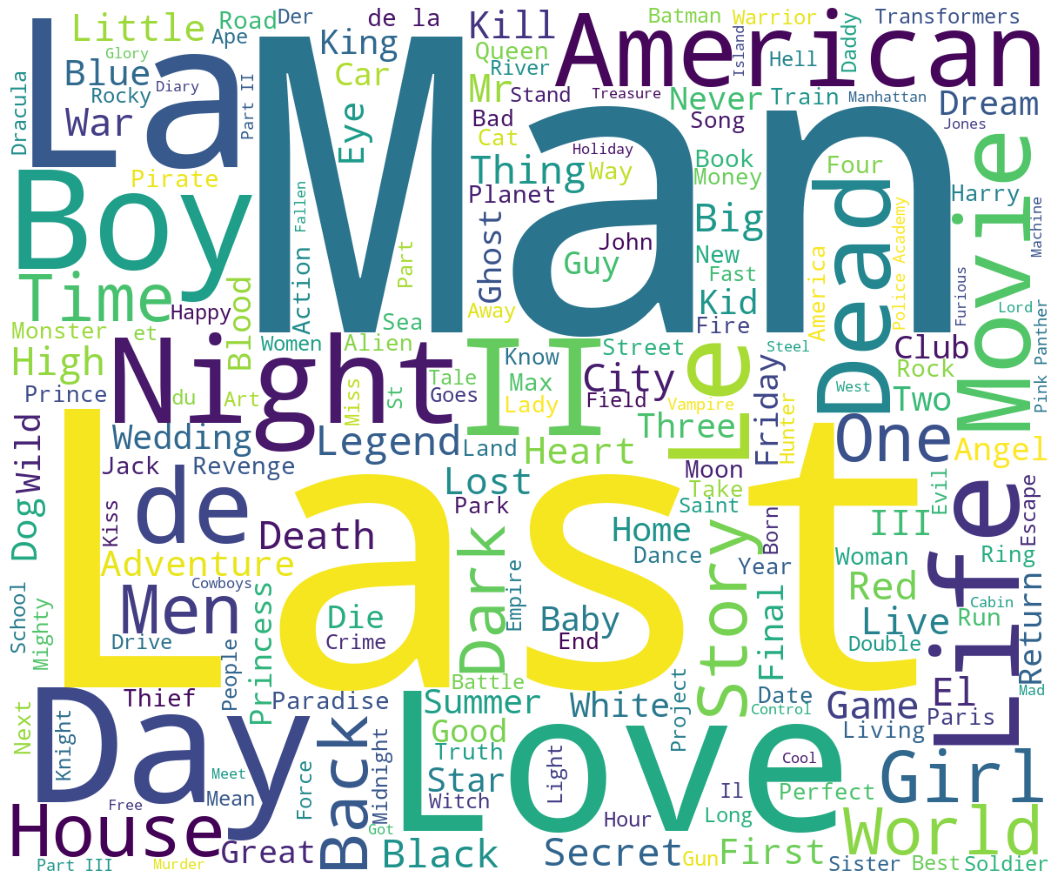

In [88]:
plt.figure(figsize=(32,16))
text = ' '.join(train['original_title'].values)
worcloud = WordCloud(max_font_size=None,background_color='white',width=1200,height=1000).generate(text)
plt.imshow(worcloud)
plt.axis('off')
plt.show()

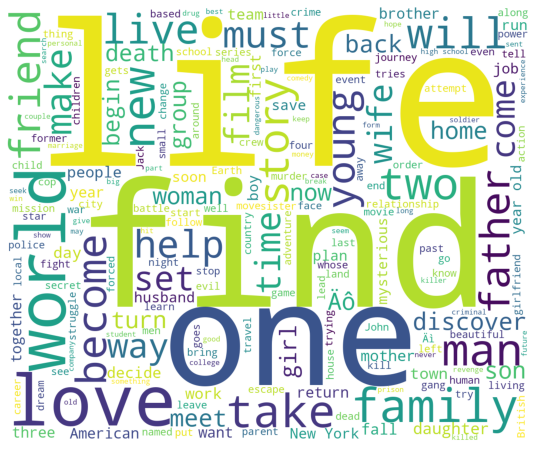

In [96]:
plt.figure(figsize=(16,8))
text = ' '.join(train['overview'].fillna('').values)
worcloud = WordCloud(max_font_size=None,background_color='white',width=1200,height=1000).generate(text)
plt.imshow(worcloud)
plt.axis('off')
plt.show()

# Task 7: Do Film Descriptions Impact Revenue?

In [2]:
#!pip install eli5

In [100]:
import eli5
from sklearn.linear_model import LinearRegression

In [102]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    min_df=5
)
overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text,train['log_revenu'])
eli5.show_weights(linreg,vec=vectorizer,top=20,feature_filter=lambda x: x!='<BIAS>')